In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

from dataloader import get_Dataframe, applyCut, applyCutsJets
from unfold import weighted_binary_crossentropy, multifold

import os
os.environ['CUDA_VISIBLE_DEVICES']="1"

import tensorflow as tf
import tensorflow.keras.backend as K
tf.random.set_seed(1234)
np.random.seed(1234)

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = '/data1/bpnachman/hera/'

In [3]:
mc_names = ['Rapgap','Rapgap','Rapgap','Rapgap','Rapgap','Rapgap','Django']
mc_tags = ['nominal','sys_0','sys_1','sys_5','sys_7','sys_11','nominal']

data_tag  = 'nominal'
period = 'ep0607'

In [4]:
reload = False #need to set this to true once, then much faster the second time.
rerun = False

In [5]:
if (reload):
    data = get_Dataframe(path, name='Data', tag=data_tag, verbose=False)
    data = applyCutsJets(data,verbose=False)
    data.to_pickle("datafiles/data.pkl")
else:
    data = pd.read_pickle("datafiles/data.pkl")

In [51]:
weights = {}
models = {}
history = {}

In [7]:
if (rerun):
    for mc_i in range(7):

        #Load files
        mc_name = mc_names[mc_i]
        mc_tag = mc_tags[mc_i]

        print("on sample:",mc_name,mc_tag)

        if (reload):
            mc = get_Dataframe(path, name=mc_name, tag=mc_tag)
            mc   = applyCutsJets(mc, isMC=True,verbose=False)
            mc.to_pickle("datafiles/"+mc_name+"_"+mc_tag+".pkl")
        else:
            mc = pd.read_pickle("datafiles/"+mc_name+"_"+mc_tag+".pkl")

        #Preprocessing
        theta_unknown_S = data[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
        theta0_S = mc[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
        theta0_G = mc[['gene_px','gene_py','gene_pz','genjet_pt','genjet_eta','genjet_phi','genjet_dphi','genjet_qtnorm']].to_numpy()
        weights_MC_sim = mc['wgt']
        pass_reco = np.array(mc['pass_reco'])
        pass_truth = np.array(mc['pass_truth'])

        #Standardize
        scaler_data = StandardScaler()
        scaler_data.fit(theta_unknown_S)

        scaler_mc_truth = StandardScaler()
        scaler_mc_truth.fit(theta0_G[pass_truth==1])

        theta_unknown_S_scaled = scaler_data.transform(theta_unknown_S)
        theta0_S_scaled = scaler_data.transform(theta0_S)
        theta0_G_scaled = scaler_mc_truth.transform(theta0_G)

        weights_MC_sim_scaled = weights_MC_sim/np.average(weights_MC_sim)

        #Acceptance effects
        theta0_S_scaled[:,0][pass_reco==0] = -10
        theta0_G_scaled[:,0][pass_truth==0] = -10

        weights_MC_sim_scaled *= len(theta_unknown_S_scaled)/len(theta0_S_scaled)

        if (mc_i==0):
            fig , ax = plt.subplots(3,3,figsize=(16,12))
            ax = ax.flatten()
            for i in range(len(theta_unknown_S[0])):
                n,b,_=ax[i].hist(theta_unknown_S_scaled[:,i],label="Data")
                ax[i].hist(theta0_S_scaled[:,i][theta0_S_scaled[:,0]!=-10],bins=b,alpha=0.5,weights=weights_MC_sim_scaled[theta0_S_scaled[:,0]!=-10],label="Sim")
                ax[i].legend()

        iterations = 5
        num_observables = 8

        for j in range(5):
            K.clear_session()
            weights[mc_i,j], models[mc_i,j], history[mc_i,j] = multifold(num_observables=num_observables,
                                   iterations=iterations,
                                   theta0_G=theta0_G_scaled,
                                   theta0_S=theta0_S_scaled,
                                   theta_unknown_S= theta_unknown_S_scaled,verbose=0,weights_MC_sim=weights_MC_sim_scaled)

In [16]:
bins = {}
dologx = [True,False,False,True]
dology = [True,False,True,True]

#jet pt
bins[0] = np.logspace(np.log10(10),np.log10(100),7)

#jet eta
bins[1] = np.linspace(-1,2.5,6)

#dphi
bins[2] = np.logspace(np.log10(0.03),np.log10(np.pi/2.0),9) - 0.03
bins[2] = bins[2][1:]
bins[2][0] = 0.0

#qt
bins[3] = np.logspace(np.log10(0.03),np.log10(3.03),9) - 0.03
bins[3] = bins[3][1:]
bins[3][0] = 0.0

In [8]:
#Let's write out everything.

import json
if (rerun):
    for mc_i in range(7):
        mc_name = mc_names[mc_i]
        mc_tag = mc_tags[mc_i]
        for iboot in range(5):
            for iiter in range(5):
                for step in range(2):
                    np.save("/data0/bpnachman/H1/"+mc_name+"_"+mc_tag+"_b"+str(iboot)+"_i"+str(iiter)+"_s"+str(step),weights[mc_i,iboot][iiter,step,:])
                    np.save("/data0/bpnachman/H1/model_"+mc_name+"_"+mc_tag+"_b"+str(iboot)+"_i"+str(iiter)+"_s"+str(step),models[mc_i,iboot][iiter,step+1])
                    myjson = json.dumps(history[mc_i,iboot]['step'+str(step+1)][iiter].history)
                    f = open("/data0/bpnachman/H1/losshistory_"+mc_name+"_"+mc_tag+"_b"+str(iboot)+"_i"+str(iiter)+"_s"+str(step)+".json","w")
                    f.write(myjson)
                    f.close()

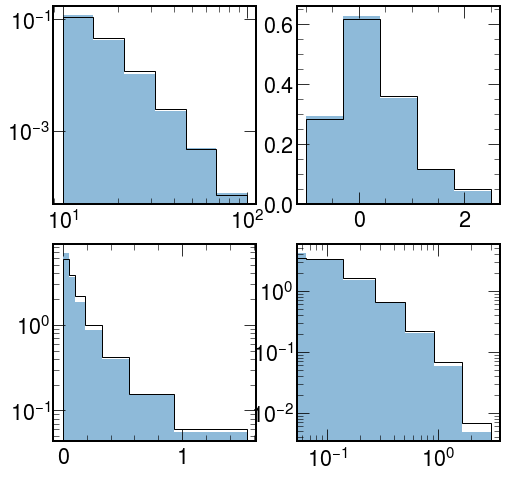

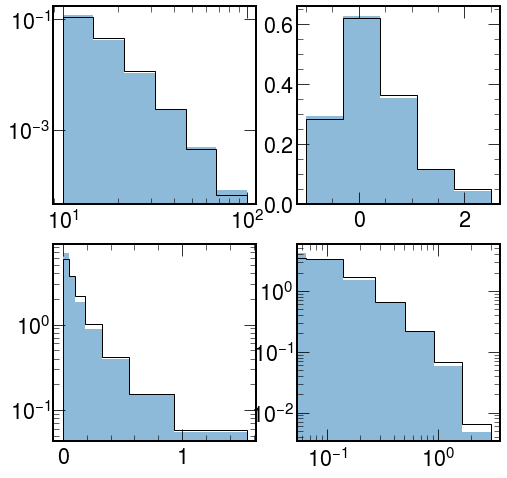

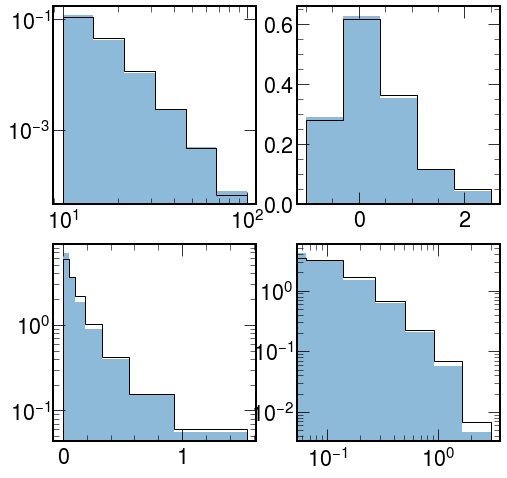

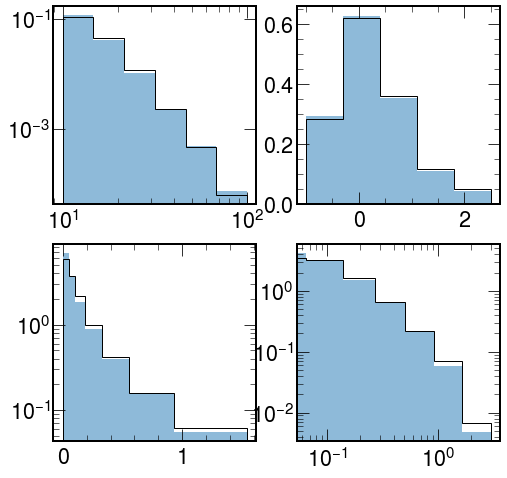

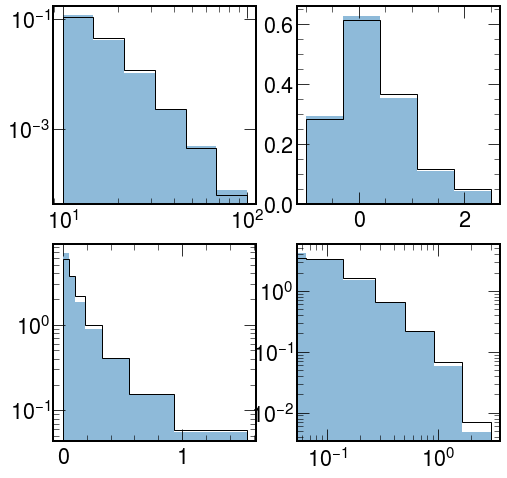

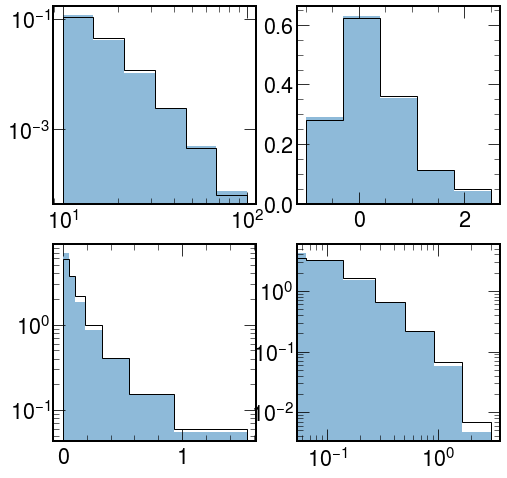

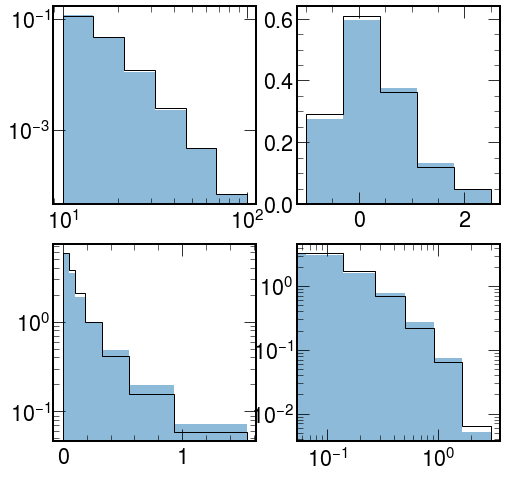

In [9]:
#Now, let's average the weights.
unfolded_vals = {}
for mc_i in range(7):
    
    #Load files
    mc_name = mc_names[mc_i]
    mc_tag = mc_tags[mc_i]

    mc = pd.read_pickle("datafiles/"+mc_name+"_"+mc_tag+".pkl")
    pass_reco = np.array(mc['pass_reco'])
    pass_truth = np.array(mc['pass_truth'])
    pass_fiducial = np.array(mc['pass_fiducial'])
    
    if (rerun):
        ww = np.mean([weights[mc_i,0][-1,1,:][pass_truth==1],
              weights[mc_i,1][-1,1,:][pass_truth==1],
              weights[mc_i,2][-1,1,:][pass_truth==1],
              weights[mc_i,3][-1,1,:][pass_truth==1],
              weights[mc_i,4][-1,1,:][pass_truth==1]],axis=0)
        np.save(mc_name+"_"+mc_tag,ww)
    else:
        ww = np.load(mc_name+"_"+mc_tag+".npy")
    
    theta0_G = mc[['genjet_pt','genjet_eta','genjet_dphi','genjet_qtnorm']].to_numpy()
    weights_MC_sim = mc['wgt']
        
    fig , ax = plt.subplots(2,2,figsize=(8,8))
    ax = ax.flatten()
    for i in range(4):
        ax[i].hist(theta0_G[pass_fiducial==1][:,i],bins=bins[i],weights=weights_MC_sim[pass_fiducial==1],density=True,alpha=0.5)
        unfolded_vals[mc_i,i],_,_ = ax[i].hist(theta0_G[pass_fiducial==1][:,i],bins=bins[i],weights=ww[pass_fiducial==1],density=True,histtype="step",color="black")
        if (dologx[i]):
            ax[i].set_xscale('log')
        if (dology[i]):
            ax[i].set_yscale('log')

In [33]:
if (rerun):
    for mykey in unfolded_vals.keys():
        np.save("outputfiles/unfolded_histos_o"+str(mykey[1])+"_s"+str(mykey[0]),unfolded_vals[mykey])

In [126]:
#Check the quality of the fits
if (False):
    for i in range(iterations):
        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].set_title('model loss')
        ax[0].set_xlabel('epoch number')
        ax[0].plot(history[0,0]['step1'][i].history['loss'][1:],'o',label='Step 1 train')
        ax[0].plot(history[0,0]['step1'][i].history['val_loss'][1:],'o',label='Step 1 test')

        ax[1].set_title('model accuracy')
        ax[1].plot(history[0,0]['step1'][i].history['accuracy'][1:],'o',label='Step 1 train')
        ax[1].plot(history[0,0]['step1'][i].history['val_accuracy'][1:],'o',label='Step 1 test')
        ax[1].legend()
        ax[1].set_xlabel('epoch number')
        ax[1].set_yscale('log')
        ax[0].legend()
        
    for j in range(iterations):
    fig , ax = plt.subplots(3,3,figsize=(16,12))
    ax = ax.flatten()
    for i in range(len(theta_unknown_S[0])):
        n,b,_=ax[i].hist(theta_unknown_S[:,i],density=True,label="Data")
        ax[i].hist(theta0_S[:,i][pass_reco==1],bins=b,alpha=0.5,density=True,label="Sim")
        ax[i].hist(theta0_S[:,i][pass_reco==1],bins=b,histtype="step",density=True,color="black",ls=":",lw=3,weights=weights[0,0][j,0,:][pass_reco==1],label="Weighted sim")
        ax[i].legend()

In [34]:
#Let's also do the non-closure uncertainty.

In [91]:
mc_i = 7

if (rerun):

    #Load files
    mc = pd.read_pickle("datafiles/"+mc_names[0]+"_"+mc_tags[0]+".pkl")
    altmc = pd.read_pickle("datafiles/"+mc_names[6]+"_"+mc_tags[6]+".pkl")

    #Preprocessing
    theta_unknown_S = data[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
    theta_unknown_S_ALTMC = altmc[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
    pass_reco = np.array(altmc['pass_reco'])
    theta_unknown_S_ALTMC = theta_unknown_S_ALTMC[pass_reco==1]
    weights_MC_ALTMC = altmc['wgt'][pass_reco==1]
    
    theta0_S = mc[['e_px','e_py','e_pz','jet_pt','jet_eta','jet_phi','jet_dphi','jet_qtnorm']].to_numpy()
    theta0_G = mc[['gene_px','gene_py','gene_pz','genjet_pt','genjet_eta','genjet_phi','genjet_dphi','genjet_qtnorm']].to_numpy()
    weights_MC_sim = mc['wgt']
    pass_reco = np.array(mc['pass_reco'])
    pass_truth = np.array(mc['pass_truth'])
    
    #Standardize
    scaler_data = StandardScaler()
    scaler_data.fit(theta_unknown_S)

    scaler_mc_truth = StandardScaler()
    scaler_mc_truth.fit(theta0_G[pass_truth==1])

    theta_unknown_S_scaled = scaler_data.transform(theta_unknown_S_ALTMC)
    theta0_S_scaled = scaler_data.transform(theta0_S)
    theta0_G_scaled = scaler_mc_truth.transform(theta0_G)

    weights_MC_sim_scaled = weights_MC_sim/np.average(weights_MC_sim)
    weights_MC_ALTMC_scaled = weights_MC_ALTMC/np.average(weights_MC_ALTMC)

    #Acceptance effects
    theta0_S_scaled[:,0][pass_reco==0] = -10
    theta0_G_scaled[:,0][pass_truth==0] = -10

    weights_MC_sim_scaled *= len(weights_MC_ALTMC)/len(theta0_S_scaled)
    
    iterations = 5
    num_observables = 8

    for j in range(5):
        K.clear_session()
        weights[mc_i,j], models[mc_i,j], history[mc_i,j] = multifold(num_observables=num_observables,
                               iterations=iterations,
                               theta0_G=theta0_G_scaled,
                               theta0_S=theta0_S_scaled,
                               theta_unknown_S= theta_unknown_S_scaled,
                               verbose=0,weights_MC_sim=weights_MC_sim_scaled,
                               weights_MC_data=weights_MC_ALTMC_scaled)

ITERATION: 1
STEP 1...


/home/bpnachman/disjets/unfold.py:60: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)


STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...
ITERATION: 1
STEP 1...
STEP 2...
ITERATION: 2
STEP 1...
STEP 2...
ITERATION: 3
STEP 1...
STEP 2...
ITERATION: 4
STEP 1...
STEP 2...
ITERATION: 5
STEP 1...
STEP 2...


In [92]:
if (rerun):
    for iboot in range(5):
        for iiter in range(5):
            for step in range(2):
                np.save("/data0/bpnachman/H1/nonclosure_"+mc_name+"_"+mc_tag+"_b"+str(iboot)+"_i"+str(iiter)+"_s"+str(step),weights[mc_i,iboot][iiter,step,:])
                np.save("/data0/bpnachman/H1/nonclosure_model_"+mc_name+"_"+mc_tag+"_b"+str(iboot)+"_i"+str(iiter)+"_s"+str(step),models[mc_i,iboot][iiter,step+1])
                myjson = json.dumps(history[mc_i,iboot]['step'+str(step+1)][iiter].history)
                f = open("/data0/bpnachman/H1/nonclosure_losshistory_"+mc_name+"_"+mc_tag+"_b"+str(iboot)+"_i"+str(iiter)+"_s"+str(step)+".json","w")
                f.write(myjson)
                f.close()

/home/bpnachman/.conda/envs/tf-gpu/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


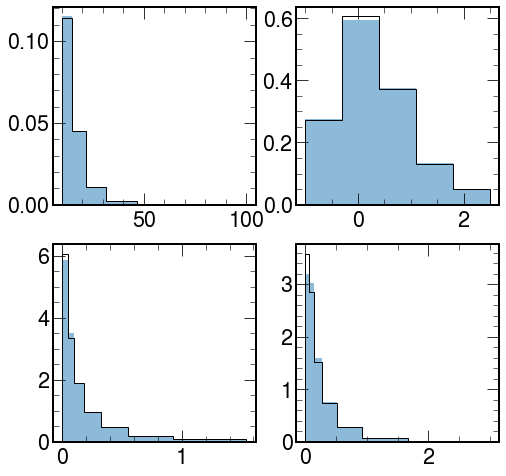

In [96]:
mc_i = 7
unfolded_vals_nonclosure = {}
    
mc = pd.read_pickle("datafiles/"+mc_names[0]+"_"+mc_tags[0]+".pkl")
altmc = pd.read_pickle("datafiles/"+mc_names[6]+"_"+mc_tags[6]+".pkl")

pass_reco = np.array(mc['pass_reco'])
pass_truth = np.array(mc['pass_truth'])
pass_fiducial = np.array(mc['pass_fiducial'])
pass_fiducial_ALTMC = np.array(altmc['pass_fiducial'])

if (rerun):
    ww = np.mean([weights[mc_i,0][-1,1,:][pass_truth==1],
          weights[mc_i,1][-1,1,:][pass_truth==1],
          weights[mc_i,2][-1,1,:][pass_truth==1],
          weights[mc_i,3][-1,1,:][pass_truth==1],
          weights[mc_i,4][-1,1,:][pass_truth==1]],axis=0)
    np.save("non_closure.npy",ww)
else:
    ww = np.load("non_closure.npy")

theta0_G = mc[['genjet_pt','genjet_eta','genjet_dphi','genjet_qtnorm']].to_numpy()
weights_MC_sim = mc['wgt']

theta0_G_ALTMC = altmc[['genjet_pt','genjet_eta','genjet_dphi','genjet_qtnorm']].to_numpy()
weights_MC_sim_ALTMC = altmc['wgt']

fig , ax = plt.subplots(2,2,figsize=(8,8))
ax = ax.flatten()
for i in range(4):
    unfolded_vals_nonclosure[8,i],_,_ = ax[i].hist(theta0_G_ALTMC[pass_fiducial_ALTMC==1][:,i],bins=bins[i],weights=weights_MC_sim_ALTMC[pass_fiducial_ALTMC==1],density=True,alpha=0.5)
    unfolded_vals_nonclosure[7,i],_,_ = ax[i].hist(theta0_G[pass_fiducial==1][:,i],bins=bins[i],weights=ww[pass_fiducial==1],density=True,histtype="step",color="black")

In [99]:
for i in range(4):
    print(i,(unfolded_vals_nonclosure[8,i]-unfolded_vals_nonclosure[7,i])/unfolded_vals_nonclosure[8,i])

0 [ 0.00943978 -0.01058684 -0.01187972 -0.00542844 -0.01606525 -0.0970615 ]
1 [ 0.02000353 -0.01868547  0.00850433  0.02369297 -0.01530867]
2 [-0.03630393  0.03833394  0.00682708  0.00738716  0.01219376  0.01426032
 -0.01376056]
3 [-0.12524122  0.05721859  0.04969528  0.03198014 -0.00581108 -0.03814734
 -0.05034656]


In [101]:
if (rerun):
    for mykey in unfolded_vals_nonclosure.keys():
        np.save("outputfiles/non_closure_histos_o"+str(mykey[1])+"_s"+str(mykey[0]),unfolded_vals_nonclosure[mykey])